# Thinkful Data Science Bootcamp
# Final Capstone

#### Emile Badran - 20/September/2018

## Introduction

In this capstone project, I process tweets from the leading Democratic (Hillary Clinton) and Republican (Donald Trump) candidates and key 2016 US election hashtags. I apply Natural Language Processing and Network Analysis techniques to find the key topics, and the most influential actors that have guided the public debate. The project aims to uncover:

- Which topics/hashtags had the most repercussion (measured in the number of comments and re-tweets) among followers of said candidates?
- What key messages can be extracted from the presidential elections public debate?
- How tightly knit were each presidential candidate’s networks?
- Who were the most influential Twitter users in the debate?

Twitter has become a major source of information and a platform for political dialogue for a considerable number of people in the US and elsewhere. By finding the most relevant topics and actors, political scientists and policy advocacy organizations can gain useful insight about a candidate’s constituency and understand the top political concerns and motivations of social network users.

## About the data set

The [2016 United States Presidential Election Tweet Ids](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PDI7IN) data set contains the tweet ids of approximately 280 million tweets related to the 2016 United States presidential election. They were collected from the Twitter API by researchers from the George Washington University between July 13, 2016 and November 10, 2016. The tweet ids are broken up into 12 collections. 

This Capstone Project uses a subset with ten thousand tweets extracted from one of the collections of the data set.

This specific collection was gathered from the Twitter API using the following seeds:

- **Hashtags:** election2016, election, clinton, kaine, trump, pence
- **Followed UserIDs:** 1339835893, 25073877, 22203756, 172858784

Link to the original research:

    Littman, Justin; Wrubel, Laura; Kerchner, Daniel, 2016, "2016 United States Presidential Election Tweet Ids", https://doi.org/10.7910/DVN/PDI7IN, Harvard Dataverse, V3

In [1]:
# set notebook display options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import modules
import time
import re
import html
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import numpy as np
from collections import Counter
import collections
import unicodedata
import json
import time
import itertools
import scipy
from random import randint
from operator import itemgetter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
import spacy
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

## Loading and cleaning the data set

The data was obtained from the Twitter API as a JSON file where each line consists of a [Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html).

We'll start by loading the data set into a list of strings. Twitter objects are stored as items in the list.

In [3]:
# locate the file
data_file = '/Users/Badran/Downloads/US_elections_filter6/microjson.json'

# load the json data file line by line into a list
file_text = []
for line in open(data_file, 'r'):
    file_text.append(json.loads(line))

# print the number of tweet objects
len(file_text)

10000

The next step is to load the JSON data into a Pandas DataFrame and filter the attributes of interest.

The data set had a few duplicate tweets that were dropped, along with messages in languages other than English.

In [4]:
# load tweets as Pandas DataFrame rows
tweets = pd.DataFrame.from_dict(line for line in file_text)

# filter columns of interest
tweets = tweets[['created_at','entities','full_text','id_str','lang',
         'quoted_status','user','favorite_count']]

# delete variable to free up memory
del file_text

# drop tweets with duplicate IDs
print('total tweets:',len(tweets))
tweets = tweets.drop_duplicates(subset=['id_str'])
print('total unique tweets:',len(tweets))

# filter only tweets in English
tweets = tweets[tweets.lang=='en']

# reset index
tweets.reset_index(inplace=True, drop=True)

# fill blank user names
tweets.user.fillna('unknown', inplace=True)

print('total unique tweets in English:', len(tweets))

total tweets: 10000
total unique tweets: 9988
total unique tweets in English: 9285


Contractions are replaced for their word combinations. This dictionary maps the most common contractions in the English language.

In [5]:
# store common contractions and their respective word combinations in a dictionary
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
  "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"}

Several data cleaning procedures are applied to the raw Tweets:
- Words are converted to lower case
- Python's *HTML Module* is used to treat unrecognized HTML objects such as "&"
- E-mail addresses, website links, hashtags, and Twitter handles (such as *@me*) are removed
- Non-english accents are converted to apostrophes
- Contractions are replaced by their word combinations
- Punctuation marks and digits are removed
- The name *Donald Trump* is replaced to *Donald* to prevent the Spacy Library from confusing "Trump" (surname) with "trump" (verb)
- Extra whitespace is removed

In [6]:
# copy the full tweet text to another column and convert to lowercase
tweets['cleaned_text'] = tweets.full_text.str.lower()
print('lower')

# unescape html characters
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: html.unescape(x))
print('unescape')

# remove e-mails
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'([\w\d_.+-]+)@([\w\d-]+)\.([a-z.]+)',
                                                     value='', regex=True)
print('emails')

# remove mentions
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'@[\w\d]+', value='', regex=True)
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'rt :', value='', regex=True)
print('mentions')

# remove links
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(http\S+)', value='', regex=True)
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(www\S+)', value='', regex=True)
print('links')

# remove hashtags
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'(?:(?<=\s)|(?<=^))#.*?(?=\s|$)',
                                                     value='', regex=True)
print('hashtags')

# replace apostrophes
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'`', value='\'', regex=True)
print('apostrophes')

# remove non-english accents
tweets.cleaned_text = tweets.cleaned_text.apply(
    lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
print('accents')

# replace contractions e.g.: "you've" to "you have"
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: expand_contractions(x))
print('contractions')

# remove all punctuation
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'[^\w\s]', value=' ', regex=True)
print('punctuation')

# remove all digits
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'\d+', value=' ', regex=True)
print('digits')

# to avoid confusing trump (noun) with trump (verb), replace donald trump for donald
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'donald trump', value='donald', regex=True)
print('donald trump')

# to avoid confusing trump (noun) with trump (verb), replace trump for donald
tweets.cleaned_text = tweets.cleaned_text.replace(to_replace=r'trump', value='donald', regex=True)
print('trump')

# remove newlines and other extra whitespace by splitting and rejoining
tweets.cleaned_text = tweets.cleaned_text.apply(lambda x: ' '.join(x.split()))
print('whitespace')

lower
unescape
emails
mentions
links
hashtags
apostrophes
accents
contractions
punctuation
digits
donald trump
trump
whitespace


In [7]:
# print the first five cleaned tweets
for i in range(5):
    print('\n{})'.format(i+1), tweets.cleaned_text[i])


1) sharing selfies of completed ballots on social media a misdemeanor in colorado

2) perfectly accurate and succinct description of courtesy of fran lebowitz

3) is being cautious of a rigged election process if not no problem

4) so are youll going to watch the dinner i do not believe donald can even make a joke i m curious

5) omg has his face gotten more orange does it glow in the dark


Approximately 38% of our sample Tweets have identical messages despite having different Tweet IDs. Since these identical messages are not retweets, there's a good chance that they were sent by robots. Robot detection is not our goal here, so we'll just drop identical Tweets.

In [8]:
# drop re-tweets
print('Number of tweets in the data set:', tweets.shape[0])
print('Number of tweets with identical messages (possibly generated by robots):',
      tweets.shape[0] - len(tweets.drop_duplicates(subset=['full_text']))
     )
tweets = tweets.drop_duplicates(subset=['cleaned_text'])
print('Number of unique tweets:', tweets.shape[0])

Number of tweets in the data set: 9285
Number of tweets with identical messages (possibly generated by robots): 3487
Number of unique tweets: 5282


We'll now extract features of interest that are nested within the Tweet Objects' *user* and *entities* attributes:
- Twitter usernames of the authors of each sample Tweet
- URLs shared in each Tweet
- Twitter usernames of the people mentioned in Tweets
- Twitter usernames of the authors of quoted Tweets

In [9]:
# declare a function that extracts the screen name of Twitter authors
def extract_ids(text):
    return text['screen_name']

# create a feature with usernames from tweets
tweets['username'] = tweets.user.apply(lambda x: extract_ids(x))


# declare a function that extracts urls from tweet objects
def extract_urls(text):
    l = []
    for i in text['urls']:
        l.append(i['expanded_url'])
    return l

# create a feature with shared urls
tweets['urls'] = tweets.entities.apply(lambda x: extract_urls(x))


# declare a function that extracts hashtags from tweet objects
def extract_hashtags(text):
    l = []
    for i in text['hashtags']:
        l.append(i['text']) 
    return l

# create a feature with a list of hashtags included on tweets
tweets['hashtags'] = tweets.entities.apply(lambda x: extract_hashtags(x))


# declare a function that extracts user mentions from tweet objects
def extract_mentions(text):
    l = []
    for i in text['user_mentions']:
        l.append(i['screen_name'])
    return l

# create a feature with a list of users mentioned on tweets
tweets['user_mentions'] = tweets.entities.apply(lambda x: extract_mentions(x))


# declare a function that extracts quoted users from tweet objects
def extract_quoted_users(text):
    return text['user']['screen_name']

# create a feature with a list of users quoted on tweets
tweets['quoted_user'] = tweets.quoted_status.apply(
    lambda x: extract_quoted_users(x) if (pd.notnull(x)) else x)

Finally, we'll filter the features of interest and convert Tweet timestamps to Pandas DateTime objects.

In [10]:
# filter features of interest
tweets = tweets[['created_at','id_str','full_text','cleaned_text',
         'urls', 'hashtags','username','user_mentions','quoted_user']]

In [11]:
# print the first row of the resulting data frame
tweets.head(1)

,created_at,id_str,full_text,cleaned_text,urls,hashtags,username,user_mentions,quoted_user
0,Thu Oct 20 23:43:00 +0000 2016,789250598004662272,Sharing selfies of completed ballots on social media a misdemeanor in Colorado - https://t.co/rBx8db3FVt\n#Election2016 https://t.co/hYnHwe0xOf,sharing selfies of completed ballots on social media a misdemeanor in colorado,[http://via.kdvr.com/bwTMv],[Election2016],KDVR,[],NaN


In [12]:
# convert creation dates into datetime objects
tweets.created_at = pd.to_datetime(tweets.created_at)

# print the dates and times of the first and last tweets
print('Start date:', tweets.created_at.min())
print('End date:', tweets.created_at.max())

Start date: 2016-10-20 23:43:00
End date: 2016-10-20 23:47:40


### Top hashtags and shared links

We have 5282 unique Tweets in English that were generated in just 4 minutes and 40 seconds!

Let's have a look at the 20 most used hashtags and most shared links.

In [13]:
# convert hashtags to lowercase
tweets.hashtags = tweets.hashtags.apply(lambda x: [i.lower() for i in x])

# append each hashtag mentions to a list
l = []
tweets.hashtags.apply(lambda x: [l.append(i) for i in x])

# count all mentioned hashtags and visualize the 20 most common
hashtag_counts = Counter(l).most_common(20)

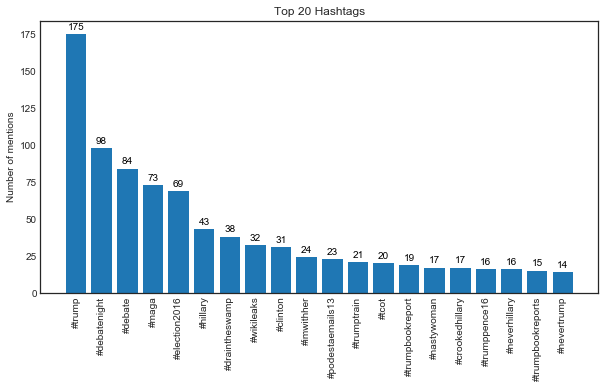

In [14]:
# plot hashtag counts
# set figure width and height
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

# set the chart x-axis labels
x = ['#'+str(i[0]) for i in hashtag_counts]

# set hashtag counts as y-values 
y = sorted([i[1] for i in hashtag_counts], reverse=True)

# plot the bar chart
plt.bar(range(20), y)
plt.xticks(range(20), x, rotation='vertical')
plt.ylabel('Number of mentions')

# plot bar values
for i, v in enumerate(y):
    plt.text(i, v+3, v, color='black', ha='center')

# set the chart title
plt.title('Top 20 Hashtags')

# display the chart inline
plt.show()

The #trump hashtag was mentioned 4x more than #hillary. The second and third most popular hashtags are related to the presidential debate that occurred on Oct. 19, 2016.

Since our data set covers only 4 minutes and 40 seconds, we couldn't capture any relevant trending website link.

In [15]:
# instantiate a list to store a sequence of all urls
l = []
tweets.urls.apply(lambda x: [l.append(i.lower()) for i in x])

# create a Counter dictionary object
# keys are urls and values are the count of how often they were shared
url_counts = Counter(l).most_common(20)

# print most common urls
for i in url_counts:
    print(i[0], '- {} shares '.format(i[1]))

# delete variable to free up system memory
del l

https://twitter.com/double_cupp_me/status/789088080426831872 - 10 shares 
https://twitter.com/cnn/status/789249378280144896 - 9 shares 
https://twitter.com/donaldjtrumpjr/status/789248030037774336 - 7 shares 
https://twitter.com/tusk81/status/789134196614631425 - 6 shares 
https://twitter.com/politico/status/789226507579326464 - 6 shares 
https://twitter.com/braddjaffy/status/789241511326183424 - 5 shares 
https://twitter.com/danmannarino/status/789248901337538562 - 5 shares 
https://twitter.com/keitholbermann/status/789243226624520194 - 5 shares 
http://bit.ly/2eyenr8 - 5 shares 
https://twitter.com/rpyers/status/789235556253249536 - 4 shares 
http://cbsnews.com/live - 4 shares 
http://www.foxnews.com/politics/2016/10/20/clintons-debate-reference-to-nuclear-response-time-raises-eyebrows.html - 4 shares 
https://twitter.com/blicqer/status/789249666923626497 - 4 shares 
http://www.breitbart.com/video/2016/10/20/cnns-starr-clintons-answer-on-nuke-launch-time-used-extremely-classified-inf

# TF-IDF and parts of speech model

Now that our Tweets are cleaned, let's do some natural language processing. Each Tweet will be treated as a sentence. We'll start by creating a "*Term-Frequency - Inverse Document Frequency model*" (TF-IDF).

The first step is to convert words to SpaCy tokens to create a bag-of-words model. Only nouns and adjectives are counted. Words that don't carry much information (called "*[Stop words](https://gist.github.com/sebleier/554280)*"), are filtered. Also, words are converted to their "*lemmas*" (or stem words) and then concatenated with their "*parts of speech*" (whether they're nouns, adjectives, etc...). Finally, only words that occur at least 20 times in our data set are taken into consideration.

The "*TF-IDF Matrix*" is then created. Unique weights are calculated for each sentence combining the *Term Frequency* and the *Inverse Document Frequency*:

$$tfidf_{t,d}=(tf_{t,d})(idf_t)$$

Where:

$$ tf_{t,d} = ft,d$$

    (number of times a term appears in a document) / (total number of terms in the document)


$$idf_t=log \dfrac N{df_t}$$
    
    log_e(Total number of documents / Number of documents with term t in it)


The TF-IDF score will be highest for a term that occurs a lot within a small number of sentences, and lowest for a word that occurs in most or all sentences.

In [16]:
# instantiate the SpaCy English module
nlp = spacy.load('en')

# define the custom tokenizing function
def my_tokenizer(doc):
    tokens = nlp(doc) # convert words in tweets to tokens
    return([(token.lemma_ + token.pos_) for token in tokens # concatenate token lemmas and parts of speech
            if not token.is_stop # skip stop words
            and not len(token.text) == 1 # skip single character tokens
            and (token.pos_=='NOUN' or token.pos_=='ADJ' or token.pos_=='ADV')]) # filter nouns, adjectives and adverbs

# set sklearn's TfidfVectorizer parameters to use our custom tokenizer function
custom_vec = TfidfVectorizer(tokenizer=my_tokenizer,
                             max_df=.5, # drop words that occur in more than XX% of the paragraphs
                             min_df=20, # only use words that appear at least X times
                             ngram_range=(1,2), # use terms with one and two words
                             use_idf=True,# use inverse document frequencies in our weighting
                             norm=False, # 'l2' applies a correction factor to treat longer and shorter paragraphs equally
                             smooth_idf=True) #Prevents divide-by-zero errors

In [17]:
# time how long the tokenizer takes to run
start_time = time.time()

# use sklearn's TfidfVectorizer to generate the tfidf matrix
tfidf_matrix = custom_vec.fit_transform(tweets.cleaned_text)

# print how long the tokenizer took to run
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.28085398674011 seconds ---


In [18]:
# instantiate series to store tokens, tweets, and hashtags information for later use
tokens = custom_vec.get_feature_names()
clean_tweets = tweets.cleaned_text
hashtags = tweets.hashtags

Rows in our matrix represent a tweet's vector. The vectors consist of the TF-IDF scores for each Spacy token in the Tweet. The value zero is assigned to tokens that aren't featured in a sentence.

# Finding topics and representative sentences

We'll use our TF-IDF vectors to calculate Sentence Similarity and identify representative tweets as those which are highly similar to other tweets. The tweets with the highest median similarity score will be sorted to identify the most important sentences in the data set.

Sklearn's *cosine_similarity* method computes similarity as *the normalized dot product of X and Y:*

$$K(X,Y) =  <X,Y> / (||X||*||Y||)$$

<img src='cosine_sim.png' width="450">

The cosine similarity of two vectors is a number between 0 and 1.0 where a value of 1.0 means the two vectors are exactly the same. The output is a similarity matrix where each row has the cosine values of that row's tweet, and all other tweets.

**Let's generate the similarity matrix and select a random sentence to find the other tweets that are most similar to it.** We'll wrap our similarity matrix in a DataFrame where both the row and column indexes are our tweets. We'll then simply filter the specific sentence's column and sort it in descending order.

In [19]:
# generate a sentence similarity matrix using Sklearn's cosine_similarity method
df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix), index=clean_tweets,
                            columns=clean_tweets) # set cleaned tweets as row and column indexes

# print a selected sentence and the 20 other sentences that are most similar to it
sentence = 'donald i will totally accept election results if i win'
df_similarity[[sentence]].sort_values(by=[sentence],ascending=False)[:20]

cleaned_text,donald i will totally accept election results if i win
cleaned_text,
donald i will totally accept the election results if i win lol,1.000000
donald i will totally accept election results if i win cnn,1.000000
donald i will totally accept election results if i win var ooyoulaplayers ooyou,1.000000
donald i will totally accept election results if i win,1.000000
donald i pledge to totally accept election results if i win via,0.971576
donald says he will totally accept election results if he wins,0.971576
donald will totally accept election results if i win reports,0.853649
omg donald just said he will totally accept results if he wins this is unbelievable,0.810032
cnn news donald i will totally accept election results if i win,0.779040


The first four sentences have a score of 1 meaning that they're perfectly identical. That's because terms such as "var", "ooyou", "lol", and "cnn" are ignored by our tfidf vectorizer.

Notice that sentences with scores above 0.5 have at least three shared words, and above 0.6 have at least six shared words. Since we're using vectors (and not simply word counts), the order of words in sentences are also taken into consideration by the model.

To find the top most representative sentences from the data set, we'll create a feature with the *mean cosine similarity score of all sentences* and rank sentences by that feature. Let's have a look at the top 20 sentences with the highest mean cosine similarity score.

In [20]:
# create a feature with the mean similarity score of each tweet
df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

# sort the similarity matrix and print the top 20 tweets with highest similarity scores
df_similarity[['mean_similarity']].sort_values('mean_similarity',ascending=False).head(20)

cleaned_text,mean_similarity
cleaned_text,
donald warns that other communities are poised to steal the election,0.107764
donald will not promise he has going to accept fraudulent stolen election,0.107764
in donald we trust,0.097612
why donald could still pull off a surprise,0.097612
box office preview can jack reacher donald,0.097612
donald is taking advantage of a certain group of his followers who lack the knowledge for critical thinking and ana,0.097612
yesterday was the least orange i ve ever seen donald,0.097612
the closest donald will ever get to an emmy is when alec baldwin wins one for playing him,0.097612
rename it lol no it will always be remembered as the failed obamacare donald,0.097612


The tweets with highest average cosine similarity score don't seem too relevant. The top *mean similarity score* among all tweets is just 0.1. That's because our data set has many tweets about many topics. Let's see if we can sort tweets by topics by creating clusters.


# Unsupervised Clustering

We'll use unsupervised clustering methods to sort our tweets by topics and then recalculate the *mean cosine similarity scores* of sentences within clusters.

#### Visualizing the geometry of our data in lower dimensions

To begin with, we'll use [Principal Component Analysis (PCA)](http://scikit-learn.org/stable/modules/decomposition.html#pca) to generate three features (also called *dimensions*) for plotting purposes. We'll plot the data in three dimensions to look at its geometry and gain insights over which clustering method to use, according to [this comparison of the clustering algorithms, also from Sklearn](http://scikit-learn.org/stable/modules/clustering.html).

Also, we'll generate Kmeans clusters of varied sizes for our first clustering attempt. Kmeans is one of the most popular clustering methods, being relatively fast and scalable.

#### K-Means Clustering

K-means is a method to cluster data points with similar variances. The algorithm tries to choose means (called centroids) that minimize inertia. The formula for inertia is:

$$\sum(\bar{x}_c - x_i)^2$$

Inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

#### Evaluating Clusters

We'll use the *silhouette coefficient* method to evaluate our clusters. For each datapoint, the coefficient is the difference between the mean distance between that datapoint and all other points in its cluster ($a_i$) and the mean distance between that datapoint and all other points in the *nearest other* cluster ($b_i$), divided by whichever of the two values is highest:  

$$\dfrac{b_i-a_i}{max(b_i,a_i)}$$

The mean of the silhouette coefficients for all datapoints is the silhouette coefficient for that clustering solution on that data.  Values range from -1 for very bad clusters to +1 for very dense clusters.

We also want to look at how our tweets are distributed among clusters. We don't want to concentrate too many of our tweets in a single cluster. We also don't want clusters with too few tweets.

In [21]:
# instantiate the Sklearn's PCA module with three components for graphing purposes
pca = PCA(n_components=3)

# fit the model and store as a dense matrix
data3D = pca.fit_transform(tfidf_matrix.todense())

# store results of PCA in a data frame
df_pca = pd.DataFrame(data3D, columns=['PCA%i' % i for i in range(3)])


Silhouette avg 5 clusters: 0.6780829625035305


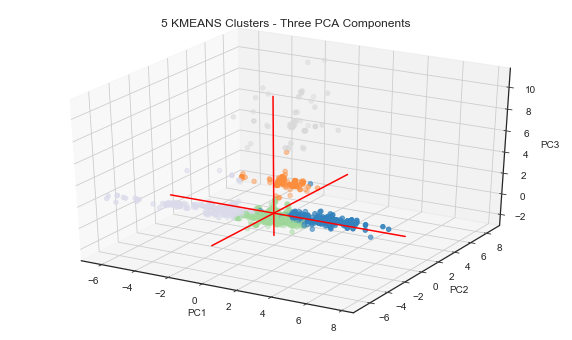

Number of observations per cluster:
2    3716
0    740 
3    548 
1    200 
4    78  
dtype: int64

-------------

Silhouette avg 10 clusters: 0.6751507335708796


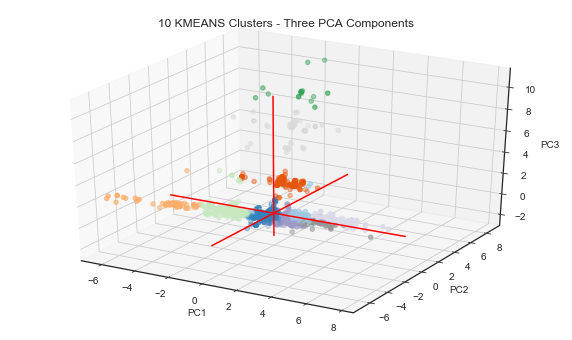

Number of observations per cluster:
0    2659
6    1006
1    521 
5    486 
2    198 
7    141 
8    98  
3    94  
9    62  
4    17  
dtype: int64

-------------

Silhouette avg 15 clusters: 0.6640718962925223


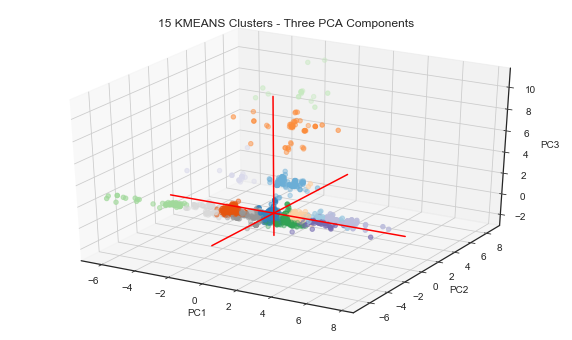

Number of observations per cluster:
0     2551
6     1007
5     486 
3     355 
1     190 
12    163 
10    96  
9     95  
7     82  
2     70  
14    69  
4     61  
13    22  
11    18  
8     17  
dtype: int64

-------------

Silhouette avg 20 clusters: 0.47638563845772464


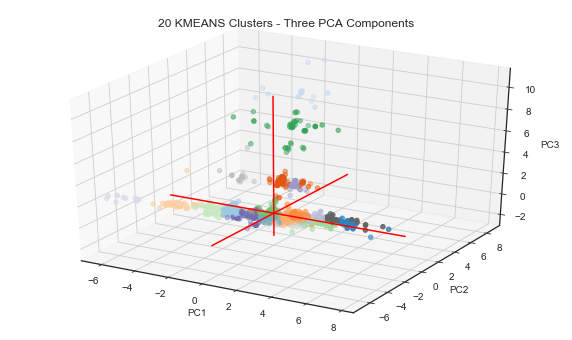

Number of observations per cluster:
9     1925
6     860 
1     681 
5     485 
2     346 
19    138 
4     123 
12    117 
10    95  
7     80  
11    70  
16    68  
13    68  
8     61  
14    55  
0     43  
17    22  
18    17  
3     17  
15    11  
dtype: int64

-------------


In [22]:
# declare a list with different cluster sizes
n_clusters = [5, 10, 15, 20]

# generate clusters of different sizes
for i in n_clusters:
    kmeans_array = KMeans(
        n_clusters=i, algorithm='full', n_init=100).fit_predict(data3D)

    # calculate and print silhouette average scores
    silhouette_avg = silhouette_score(data3D, kmeans_array)
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_avg)

    # plot PCA components on a 3d scatterplot
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_pca['PCA0'], df_pca['PCA1'], df_pca['PCA2'], c=kmeans_array, cmap="tab20c", s=20)

    # draw x, y, and z axis lines through space:
    xAxisLine = ((min(df_pca['PCA0']), max(df_pca['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(df_pca['PCA1']), max(df_pca['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(df_pca['PCA2']), max(df_pca['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes and set the chart title
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("{} KMEANS Clusters - Three PCA Components".format(i))
    
    # plot chart for each cluster size
    plt.show()

    # print the number of obserations per cluster
    print('Number of observations per cluster:')
    print(pd.value_counts(kmeans_array))
    print('\n-------------')

We can see that our data does not have a flat geometry (some observations were plotted with z-axis values higher than zero). Cluster sizes are uneven. There seems to be many clusters and they are mostly connected to each other.

Also, the shape of the data is definitely not [isotropic](https://en.wikipedia.org/wiki/Isotropy). The geometry does not have similar values when measured in different directions, but is rather stretched along the x-axis. This indicates that Kmeans is not the ideal clustering method for this data set.

Let's try using Agglomerative Clustering. According to Sklearn, the usecase for this method is when you have "*many clusters, possibly connectivity constraints, non Euclidean distances*".

Also, Agglomerative Clustering is a hierarchical clustering method, which may be useful for NLP data where there can be subtopics within topics. This may be the case with the observations that are plotted with z=0, and that are spread along the x=axis.

Still according to Sklearn, *the [AgglomerativeClustering](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering) object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy: Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.*


Silhouette avg 5 clusters: 0.6773873261438434


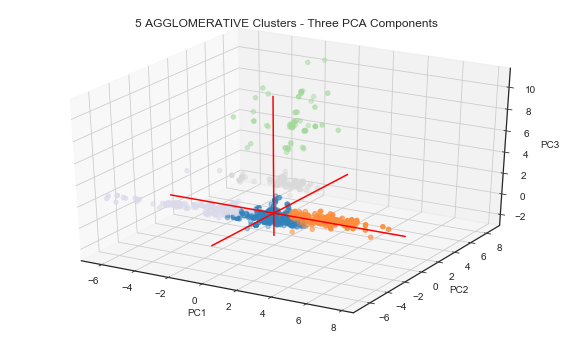

Number of observations per cluster:
0    3720
1    752 
3    526 
4    205 
2    79  
dtype: int64

-------------

Silhouette avg 10 clusters: 0.6292123443303207


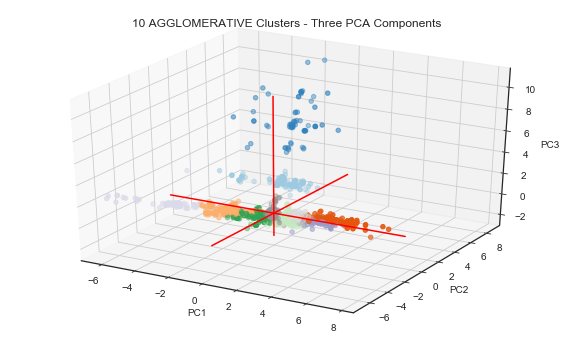

Number of observations per cluster:
8    2451
5    980 
9    484 
3    433 
4    289 
1    205 
2    158 
6    110 
7    93  
0    79  
dtype: int64

-------------

Silhouette avg 15 clusters: 0.6320440420406536


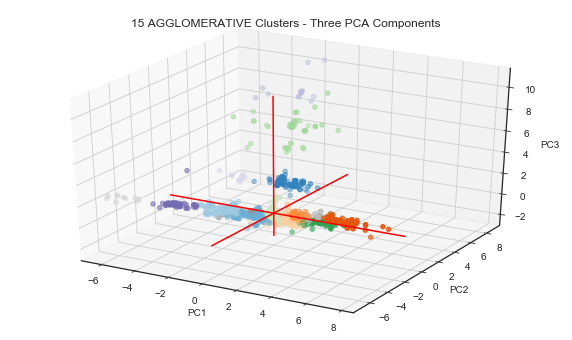

Number of observations per cluster:
8     2451
5     980 
4     484 
2     412 
1     289 
0     190 
6     110 
3     108 
9     82  
7     64  
13    50  
12    21  
11    15  
10    15  
14    11  
dtype: int64

-------------

Silhouette avg 20 clusters: 0.6000962571050314


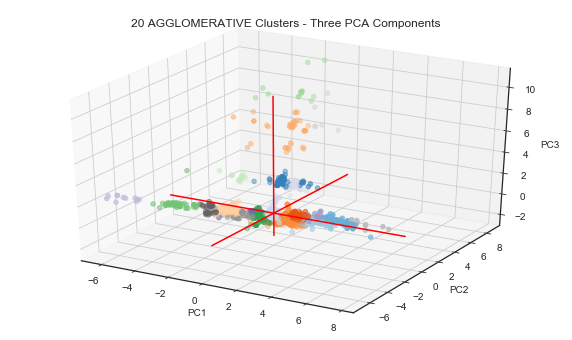

Number of observations per cluster:
3     2451
5     980 
4     484 
7     360 
8     214 
0     123 
2     110 
1     97  
9     82  
17    75  
15    67  
6     57  
16    52  
13    50  
12    21  
10    15  
11    15  
14    11  
18    11  
19    7   
dtype: int64

-------------


In [25]:
# generate clusters of different sizes
for i in n_clusters:
    ac_array = AgglomerativeClustering(
        n_clusters=i, linkage='ward').fit_predict(data3D)

    # calculate and print silouette average scores
    silhouette_avg = silhouette_score(data3D, ac_array)
    print('\nSilhouette avg {} clusters:'.format(i), silhouette_avg)

    # Plot initialisation
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_pca['PCA0'], df_pca['PCA1'], df_pca['PCA2'], c=ac_array, cmap="tab20c", s=20)

    # draw x, y, and z axis lines through space:
    xAxisLine = ((min(df_pca['PCA0']), max(df_pca['PCA0'])), (0, 0), (0,0))
    ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
    yAxisLine = ((0, 0), (min(df_pca['PCA1']), max(df_pca['PCA1'])), (0,0))
    ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
    zAxisLine = ((0, 0), (0,0), (min(df_pca['PCA2']), max(df_pca['PCA2'])))
    ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

    # label the axes
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("{} AGGLOMERATIVE Clusters - Three PCA Components".format(i))
    plt.show()

    # print the number of obserations per cluster
    print('Number of observations per cluster:')
    print(pd.value_counts(ac_array))
    print('\n-------------')

Kmeans and Agglomerative Clustering produce similar results, both in terms of their silhouette scores and cluster sizes. Kmeans seems to have better grouped the data plotted on the z-dimension (or third component). This may be an indication that the method will be better fit for higher dimensional data.

#### Dimension reduction
Our data has many dimensions so it's worthwhile doing some dimension reduction before generating our final clusters.  We'll use the Singular Value Decomposition (SVD) function from sklearn rather than PCA because we don't want to mean-center our variables (and thus lose sparsity). SVD works well with sparse matrices and is frequently used on TF-IDF matrices.

In [26]:
print('TF-IDF matrix shape', tfidf_matrix.shape)

# time how long it takes to generate SVD components
start_time = time.time()

# use SVD to reduce the feature space and normalize the matrix
svd = TruncatedSVD(150)
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# inspect the variance explained by our reduced features
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()

print("--- %s seconds ---" % (time.time() - start_time))

print("Percent variance captured by all components:", total_variance*100)
print('LSA matrix shape', lsa_matrix.shape)

TF-IDF matrix shape (5282, 223)
--- 0.49655795097351074 seconds ---
Percent variance captured by all components: 86.02332385337428
LSA matrix shape (5282, 150)


Let's iteratively generate Kmeans clusters with varied sizes and measure their silhouette scores. We'll choose the number of clusters that not only produces higher scores, but also clusters with similar sizes.

In [27]:
# declare cluster sizes
n_clusters = [5,6,10,15,20]

# generate kmeans clusters of varied sizes and time how long it takes
for i in n_clusters:

    start_time = time.time()
    
    kmeans_array = KMeans(
        n_clusters=i, algorithm='full', n_init=50).fit_predict(lsa_matrix)
    
    # print the time taken to generate clusters
    print("\n--- {} seconds ---".format(time.time() - start_time))

    # calculate and print average silhouette scores of clusters
    silhouette_avg = silhouette_score(lsa_matrix, kmeans_array)

    print('Silhouette avg {} clusters:'.format(i), silhouette_avg)
    
    # print the number of samples per cluster
    print(pd.value_counts(kmeans_array))


--- 5.4523398876190186 seconds ---
Silhouette avg 5 clusters: 0.09285701844620843
4    3070
1    719 
2    675 
3    558 
0    260 
dtype: int64

--- 5.2260730266571045 seconds ---
Silhouette avg 6 clusters: 0.0983398900439134
2    3036
1    661 
3    525 
5    522 
0    281 
4    257 
dtype: int64

--- 4.79003381729126 seconds ---
Silhouette avg 10 clusters: 0.10850325470149388
3    3076
1    516 
9    403 
8    281 
6    251 
0    233 
2    216 
5    142 
7    103 
4    61  
dtype: int64

--- 6.087994813919067 seconds ---
Silhouette avg 15 clusters: 0.12978615412194955
2     2722
13    538 
11    378 
1     252 
10    232 
0     223 
9     145 
3     134 
8     118 
5     117 
4     103 
7     102 
14    92  
12    81  
6     45  
dtype: int64

--- 6.977928400039673 seconds ---
Silhouette avg 20 clusters: 0.1453445742987584
3     2558
11    368 
15    291 
9     239 
5     224 
2     214 
14    146 
10    146 
13    146 
17    145 
4     135 
12    98  
18    97  
6     87  
0     8

Although smaller clusters will generally have higher silhouette scores, we may not want to have clusters with too few samples, as it may be difficult to extract information from them. In this context, the best silhouette score / cluster sizes option seems to be 15 Kmeans clusters.

In [28]:
# declare the number of clusters
n_clusters = 15

# time how long it takes to generate the final clusters
start_time = time.time()

# generate clusters
kmeans_array = KMeans(n_clusters=n_clusters, algorithm='full', n_init=50).fit_predict(lsa_matrix)

# calculate and print average silhouette score of clusters
silhouette_avg = silhouette_score(lsa_matrix, kmeans_array)

print('Silhouette avg = {}'.format(silhouette_avg))

# print how long it took to generate clusters
print("\n--- {} seconds ---".format(time.time() - start_time))

# print the number of samples in each cluster
print(pd.value_counts(kmeans_array))

Silhouette avg = 0.1285328673824234

--- 8.238213300704956 seconds ---
2     2735
9     443 
6     397 
11    262 
14    235 
5     216 
13    148 
3     146 
12    143 
4     138 
0     126 
7     102 
8     79  
10    61  
1     51  
dtype: int64


### Inspecting the distribution of hashtags in clusters

Let's count the occurence of the top 20 hashtags within our clusters and see if they've been sorted in any way.

In [29]:
# store the LSA matrix in a pandas dataframe
df = pd.DataFrame(lsa_matrix, index=clean_tweets)

# insert a column to store kmeans clusters
df.insert(0,'kmeans', 0)

# add a feature with kmeans cluster values
df['kmeans'] = kmeans_array

# generate a list with the top hashtags
top_hashtags = [i[0] for i in hashtag_counts]

# insert zero-valued columns with the names of the top hashtags
for i in top_hashtags:
    df.insert(1,i,0)

# insert column with hashtags shared in each tweet
df.insert(0, 'hashtags', hashtags.values)

# print the first row of the resulting data frame
df.head(1)

,hashtags,kmeans,nevertrump,trumpbookreports,neverhillary,trumppence16,crookedhillary,nastywoman,trumpbookreport,tcot,trumptrain,podestaemails13,imwithher,clinton,wikileaks,draintheswamp,hillary,election2016,maga,debate,debatenight,trump,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,...,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
cleaned_text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
sharing selfies of completed ballots on social media a misdemeanor in colorado,[election2016],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.077752,-0.003631,-0.008485,-0.028666,-0.00185,0.048987,0.055284,-0.00995,-0.037598,-0.090813,-0.096017,0.048486,0.02838,-0.118081,-0.054232,0.306176,0.430404,0.451873,-0.088441,-0.1424,-0.205556,-0.086169,-0.218643,0.05228,0.086599,0.139782,-0.138704,-0.038923,...,0.012621,-0.036963,-0.001519,0.144072,0.035376,0.047252,-0.061195,0.042944,-0.090552,0.069594,-0.011149,-0.097218,0.049778,-0.061449,0.023414,0.040716,-0.09694,0.054088,-0.035264,0.054262,0.005984,-0.031425,0.033062,0.042979,0.044127,-0.002782,0.04833,-0.019017,-0.004858,0.035626,0.025816,0.039268,0.020206,0.091773,0.011081,-0.003454,-0.099277,0.078663,0.006161,-0.008214,0.041914,-0.047687,0.007391,-0.047718,0.008886,-0.030741,0.073476,-0.007765,-0.063647,-0.002333


In [30]:
# reset the dataframe index
df.reset_index(inplace=True)

# count the occurrence of each of the top hashtags
for i, hashlist in enumerate(df.hashtags):
    for hashtag in hashlist:
        if hashtag in top_hashtags:
            df.loc[i,hashtag]+=1

# add a column with the values of the kmeans clusters
tweets['kmeans_clusters'] = df.kmeans.values

# print a few selected columns and rows to check if counts are done properly
df[['hashtags','maga','trumppence16','debatenight']][df.maga!=0].head(6)

,hashtags,maga,trumppence16,debatenight
34,[maga],1,0,0
67,"[debatenight, maga]",1,0,1
69,[maga],1,0,0
220,"[economy, trumppence2016, maga]",1,0,0
245,[maga],1,0,0
297,"[trumppence16, maga]",1,1,0


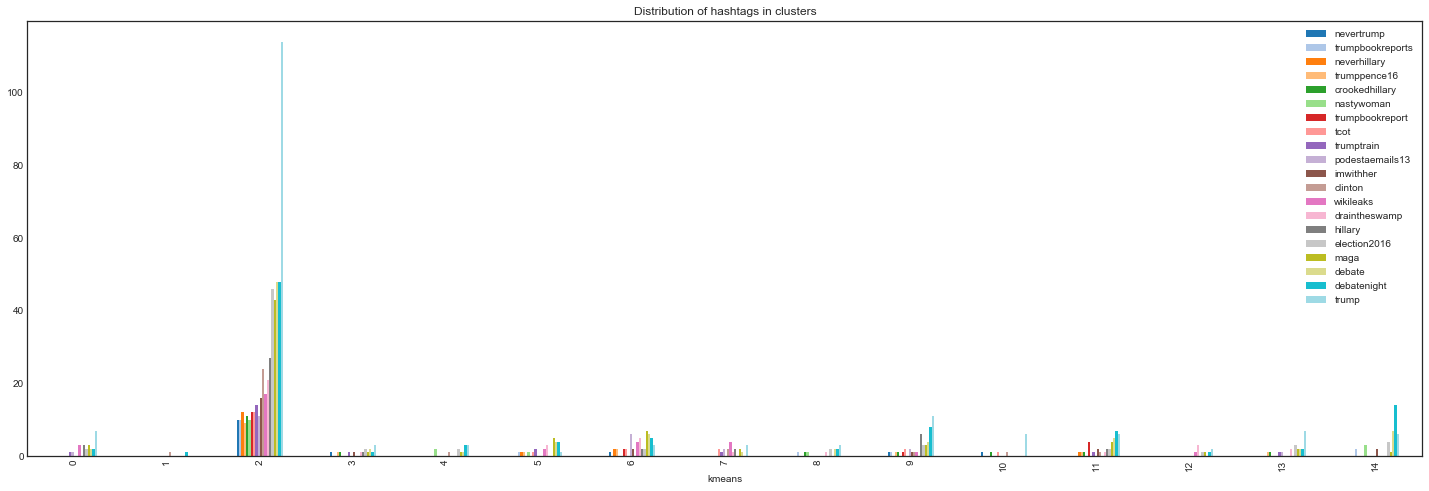

In [31]:
# plot the count of hashtags in each cluster
df.iloc[:,2:23].groupby('kmeans').sum().plot.bar(figsize=(25,8),colormap='tab20')
plt.title('Distribution of hashtags in clusters')
plt.show()

### Cosine similarity scores of clusters

It looks like our hashtags are distributed among all clusters, which doesn't help us say whether our clusters have successfully sorted topics together. Let's calculate the **average cosine similarity of each cluster** to see if they're grouping similar tweets together. We'll also **rank sentences within clusters by their _mean cosine similarity scores_** and see if this helps us find representative topics.

Once again, we'll use Sklearn's cosine_similarity method to generate a similarity matrix, with the cleaned tweets as both column and row indexes.

In [32]:
# this function iterates over clusters and calculates the average cosine similarity score of tweets
def get_similarities(num_sents):
    
    # create an empty ordered dictionary
    sim_sents = collections.OrderedDict()
    
    # create an empty dictionary to temporarily store values 
    mean_sims = {}
    
    # iterate over clusters
    for i in range(n_clusters):
        
        # calculate cosine similarity with Sklearn's cosine_similarity method and store in dataframe
        df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix[kmeans_array==i,:]),
                                   index=clean_tweets[kmeans_array==i], # cleaned tweets as index
                                   columns=clean_tweets[kmeans_array==i]) # cleaned tweets as columns
        
        # insert a column with the average similarity score of each row in the similarity matrix
        df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))
        
        # calculate the cluster's global average similarity score
        mean_similarity = df_similarity.mean_similarity.mean()
        
        # store the cluster's global average similarity score on a dictionary
        mean_sims['cluster {}'.format(i)] = mean_similarity

        # rank and extract the most similar tweets
        top_sents = df_similarity.sort_values('mean_similarity',ascending=False)[:num_sents].index
        
        # store the most similar tweets and the average similarity score of clusters
        sim_sents['cluster_{} | {} tweets | mean similarity: {}'.format(
            i, df_similarity.shape[0], mean_similarity)] = top_sents

    return sim_sents, mean_sims

Let's print out the tweets in one of the clusters, along with the number of tweets and the cluster's mean similarity score.

In [36]:
# call the get_similarities function
sim_10, cluster_sims = get_similarities(10)

# print the top ten tweets and mean similarity score of cluster 0
print('cluster_0 | 126 tweets | mean similarity: 0.32165569776481756')

for i, tweet in enumerate(sim_10['cluster_0 | 126 tweets | mean similarity: 0.32165569776481756']):
    print('\n{})'.format(i),tweet)

cluster_0 | 126 tweets | mean similarity: 0.32165569776481756

0) does the media bias charge hurt or motivate you yes it hurts panel

1) the frustrating paradox of disability in the media about us without us

2) dream on melania the media never even wanted near my story until the access hollywood tape aired i had no c

3) ross douthat column how will donald be reborn a media mogul another run in will he create a protege

4) that ll be an inevitability of a hrc admin a massive spinning effort abetted by her vast network of media allies donald has n

5) evidence showing media collusion with hillary clinton

6) tavis smiley holds nothing back against media for helping to create donald

7) breaking member of kennedy clan horrifies media with epic donald endorsement adam walinsky fo

8) anonymous delivers november th warning to mainstream media donald pence

9) the idiots in conservative media who shilled for donald in the primary will never take responsibility because they are all


In [37]:
# print the max, min, and average similarity scores from all clusters
print('Maximum cluster similarity:', max(cluster_sims.values()))
print('Minimum cluster similarity:', min(cluster_sims.values()))
print('Mean cluster similarity:', np.mean(list(cluster_sims.values())))

# print the similarity scores of each cluster
cluster_sims

Maximum cluster similarity: 0.821630528388023
Minimum cluster similarity: 0.011941781966179444
Mean cluster similarity: 0.38496077800059486


{'cluster 0': 0.32165569776481756,
 'cluster 1': 0.4097922444762456,
 'cluster 10': 0.6092505649643915,
 'cluster 11': 0.31267646187648046,
 'cluster 12': 0.37758318961337023,
 'cluster 13': 0.4038792493962182,
 'cluster 14': 0.35088704388564834,
 'cluster 2': 0.011941781966179444,
 'cluster 3': 0.3797923693381268,
 'cluster 4': 0.4149891233962513,
 'cluster 5': 0.821630528388023,
 'cluster 6': 0.24371846911009956,
 'cluster 7': 0.4112052076184782,
 'cluster 8': 0.4229835345219178,
 'cluster 9': 0.28242620369267546}

Cluster 0 does seems to group tweets about the **media** in general. Not surprisingly, Cluster 2 has the greatest number of obsertations (2735) and the lowest cosine similarity score (0.0119).

### Topic extraction

If we break down the clusters further, we may find *Latent Variables*, which can be thought of as hidden topics within the data. For example, the word *election* may be featured in different hidden topics (e.g., *election day* vs. *election result*). We’ll use **Non-Negative Matrix Factorization** (NNMF) to extract our latent variables.

NNMF is a dimension reduction method similar to PCA that searches for two matrices that, when multiplied together, result in the original TF-IDF matrix. The method applies a constraint that all three matrices must contain no negative values, leading to approximate values:

$$tfidf \approx WH$$

In text modeling, $W$ represents the topics, and $H$ describes whether, and to what extent, each topic applies to each document.

Sklearn's NNMF method applies the coordinate descent algorithm to find values for $W$ and $H$ that result in a matrix as close to the original TF-IDF matrix as possible. As with LSA, the goal is to reproduce the TF-IDF matrix using a smaller set of components, which we then call 'topics.' Components with the highest loading indicate a greater probability of featuring a given topic.

We'll use NMF to extract topics from clusters. To do so, we'll apply NMF to each cluster in our TF-IDF matrix and **generate a _components matrix_ where the rows are the TF-IDF vectors of all tweets within a cluster, and the columns are the NMF components**. The number of resulting components will be proportional to the number of tweets within clusters.

Then, for each *components matrix*, we'll iterate over its columns and **extract the top ten tweets that have the highest component loadings**.

In [38]:
# define a function to extract the main topics in each cluster
def extract_topics(method, tfidf_mtx, num_sents):
    
    # create an empty ordered dictionary
    sim_sents = collections.OrderedDict()

    # iterate over each cluster
    for i in range(n_clusters):
        
        # generate an array with the cluster's cleaned tweets
        temp_index = clean_tweets[kmeans_array==i]
        
        # calculate the number of observations in the cluster
        len_cluster = len(temp_index)
        
        # filter a matrix with the tfidf vectors of the tweets that are part of the cluster
        temp_matrix = tfidf_mtx[kmeans_array==i,:]
        
        # calculate the number of components
        n_components = int(np.ceil(temp_matrix.shape[0] * .01)) # one component for every 100 tweets within clusters
        if n_components > 10: # maximum of 10 components
            n_components = 10

        # print the cluster's number of observations 
        print('Cluster {}: {} observations'.format(i, len_cluster))
        
        # instantiate SVD, LDA and NMF to reduce the feature space and normalize the matrix
        svd = TruncatedSVD(n_components)
        lsa = make_pipeline(svd, Normalizer(copy=False))
        
        lda = LDA(n_components=n_components,
                  doc_topic_prior=None, # prior = 1/n_documents
                  topic_word_prior=1/20,
                  learning_decay=0.7, # convergence rate
                  learning_offset=10.0, # causes earlier iterations to have less influence on the learning
                  max_iter=20, # when to stop even if the model is not converging (to prevent running forever)
                  evaluate_every=-1, # do not evaluate perplexity, as it slows training time
                  mean_change_tol=0.001, # stop updating the document topic distribution in the E-step when mean change is < tol
                  max_doc_update_iter=100, # when to stop updating the document topic distribution in the E-step even if tol is not reached
                  n_jobs=1, # set to -1 to use all available CPUs to speed up processing time
                  verbose=0, # amount of output to give while iterating
                  random_state=0
                 )

        nmf = NMF(alpha=0.0, 
                  init='nndsvdar', # how starting value are calculated
                  l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
                  max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
                  n_components=n_components, 
                  random_state=0, 
                  solver='cd', # Use Coordinate Descent to solve
                  tol=0.0001, # model will stop if tfidf-WH <= tol
                  verbose=0 # amount of output to give while iterating
                 )

        # generate the components matrix according to the method of choice
        if method == 'lsa':
            components = lsa.fit_transform(temp_matrix)
            print('Explained variance ratio:', sum(svd.explained_variance_ratio_))

        elif method == 'lda':
            components = lda.fit_transform(temp_matrix)

        else:
            components = nmf.fit_transform(temp_matrix)

        # save components to file
        np.save('{}_cl_{}.npy'.format(method, i), components)
        
        # store components in a data frame
        df_components = pd.DataFrame(components, index=clean_tweets[kmeans_array==i])
        
        # extract the top tweets for each component and store them in a dictionary
        for col in df_components.columns:
            top_sents = df_components[col].sort_values(ascending=False)[:num_sents].index
            sim_sents['cluster_{}, component {}'.format(i, col)] = top_sents

    # return a dictionary with the top sentences from each component in each cluster
    return sim_sents

Cluster 12 has two components. Let's print their top sentences.

In [39]:
# use nmf to generate components for each cluster and extract their top tweets
nmf_topics = extract_topics('nmf', tfidf_matrix, 10)

# print the top sentences in cluster 12
for key, value in nmf_topics.items():
    if (key == 'cluster_12, component 0') or (key == 'cluster_12, component 1'):
        print('\n--------------\n',key)
        for j, sent in enumerate(value):
            print('\n{})'.format(j),sent)

Cluster 0: 126 observations
Cluster 1: 51 observations
Cluster 2: 2735 observations
Cluster 3: 146 observations
Cluster 4: 138 observations
Cluster 5: 216 observations
Cluster 6: 397 observations
Cluster 7: 102 observations
Cluster 8: 79 observations
Cluster 9: 443 observations
Cluster 10: 61 observations
Cluster 11: 262 observations
Cluster 12: 143 observations
Cluster 13: 148 observations
Cluster 14: 235 observations

--------------
 cluster_12, component 0

0) look at cool headed obama running around doing her job what a mug he has proper flaping squeaky bum time obama donald president

1) look at the campaigne hillary obama and others said the system is rigged obama and hillary are paying to have it rigged emails

2) news michelle obama blasts donald as out of touch elitist first lady michelle obama ratche

3) obama in miami obama feeds us with his hope donald feeds himself on our

4) first lady michelle obama took the stage in phoenix today in support of hillary clinton s campaign

Although cluster 12 component 0 seem to group all tweets that include the name "Obama", there doesn't seem to be one specific topic in that cluster. Cluster 12 component 1, on the other hand, groups tweets with the terms "obama", "said", "claims", "calls, "election", and "dangerous". 

We can't apply cosine similarity to our component matrices, since each matrix will have the same tweets as our clusters.

Let's instead **extract top keywords from each component** and see if those keywords summarize the main topics within each component.

To do so, we'll take our component matrices and multiply them by the transpose of our TF-IDF matrix. The result will be a new matrix for each cluster, where the row index is our tokens (originally in the TF-IDF matrix columns) and the columns are our NMF components.

We'll then extract the top words (to be more precise the top tokens) with the highest component loadings.

In [40]:
# define a function to extract the tokens with the highest component loadings
def get_top_words(method, n_top_words):
    
    # create an empty ordered dictionary
    topwords_dict = collections.OrderedDict()
    
    # iterate over clusters
    for i in range(n_clusters):
        
        # filter a matrix with the tfidf vectors of the component's tweets
        tfidf_mtx = tfidf_matrix[kmeans_array==i]
        
        # open the file where the respective component matrix is stored
        try: # skip the step if the file does not exist
            filename = '{}_cl_{}.npy'.format(method, i)
            comp_matrix = np.load(filename)
            #print('cluster {} - {} tweets'.format(i, comp_matrix.shape[0]))
        except FileNotFoundError:
            continue        

        # load scores for each token on each component and wrap in dataframe
        df_wordloads = pd.DataFrame(tfidf_mtx.T.dot(comp_matrix), index=tokens)

        # sort top words for each component column
        for column in df_wordloads.columns:
            sortedwords = df_wordloads.iloc[:,column].sort_values(ascending=False)

            # choose the N highest loadings
            chosen = sortedwords[:n_top_words]

            # create an ordered dictionary to store the top words and their component loadings
            temp_dict = collections.OrderedDict()

            # combine loading and index into an ordered dict
            temp_dict['{}_{}'.format(i, column)] = collections.OrderedDict(
                zip(chosen.index, round(chosen,2)))

            # store each cluster's top words and component loadings in a dictionary
            topwords_dict.update(temp_dict)
    
    # save dict to file
    np.save('topwords_{}.npy'.format(method), topwords_dict)

    return topwords_dict

In [41]:
# call the function
nmf_top_words = get_top_words('nmf', 10)

# print the top words and component loadings from cluster 12, component 0
print('\nList of topics - COMPONENT CLASS 12_0:')

nmf_top_words['12_0']


List of topics - COMPONENT CLASS 12_0:


OrderedDict([('obamaNOUN', 357.62),
             ('presidentNOUN', 70.98),
             ('donaldNOUN', 52.19),
             ('obamaNOUN donaldNOUN', 32.46),
             ('ladyNOUN', 30.0),
             ('campaignNOUN', 24.57),
             ('dangerousADJ', 22.25),
             ('electionNOUN', 21.48),
             ('clintonNOUN', 21.34),
             ('americaNOUN', 20.51)])

**Indeed the list of topics extracted from component class 12_0 are similar to the list of top 10 sentences from that same component class.** These lists of topics can serve as useful references for researchers who want to sort through the main topics in the Twitter political debate.

## Classifying sentences by cluster and component

Let's see if we can now assign a "*topic class*" to each tweet. We'll load our component matrices, and create a "*top component*" column feature using Panda's idxmax() function. The new feature will indicate, for each Tweet, the number of the component with the highest loading. **We'll then get back to our original Tweets dataframe and assign for each tweet its *topic class*, consisting of the number of its cluster combined with the number of its component with the highest loading.**

In [42]:
# create the comp_class column with null values
tweets['comp_class'] = np.nan

# iterate over clusters
for i in range(n_clusters):
    
    # create a temporary, empty data frame to store values
    temp_df = pd.DataFrame()
    
    # open files with component matrices and store the matrices in the temporary data frame
    try:
        filename = 'nmf_cl_{}.npy'.format(i)
        matrix = np.load(filename)
        temp_df = pd.DataFrame(data=matrix, index=clean_tweets[kmeans_array==i])

    # skip the step if the file does not exist
    except FileNotFoundError:
        tweets.loc[(tweets.kmeans_clusters==i), ['comp_class']] = '{}_0'.format(i)
        continue        
    
    # create a column with the index of the column that has the highest component loading value
    temp_df.insert(0, 'top_comp', temp_df.idxmax(axis=1))

    # store the name of the component class
    temp_df['comp_class'] = str(i) + '_' + temp_df['top_comp'].astype(str)
    
    # copy the component classes to the tweets data frame
    tweets.loc[(tweets.kmeans_clusters==i), ['comp_class']] = temp_df.comp_class.values

Let's start by looking at the average silhouette score of all component classes.

In [43]:
# print the number of component classes and average silhouette score of all classes
print('Number of component classes:', len(tweets.comp_class.unique()))
print('Average silhouette score of component classes:',
      silhouette_score(lsa_matrix, tweets.comp_class))

Number of component classes: 43
Average silhouette score of component classes: 0.12413272586467372


Recall that the silhouette average of our 15 components is 0.1285. We now have 43 component classes, with a similar average silhouette score.

Let's calculate the cosine similarity scores for each component class. I'll also manually review a few component classes and make some anecdotal observations about them.

In [44]:
# create a variable with a copy of the component classes
c_class_array = tweets.comp_class.values

# create an empty dictionary to store mean similarity scores
mean_sims = {}

# iterate over component classes
for i in c_class_array:
    
    # create a temporary variable with a copy of the cleaned tweets for each component class
    tweets_array = tweets.cleaned_text[tweets.comp_class==i].values

    # generate a similarity matrix for each component class and store in a temporary data frame
    df_similarity = pd.DataFrame(cosine_similarity(tfidf_matrix[c_class_array==i]),
                               index=tweets_array,
                               columns=tweets_array)

    # create a column with the mean similarity scores of each tweet
    df_similarity.insert(0, 'mean_similarity', df_similarity.mean(axis=1))

    # calculate the global mean similarity score of each component class
    mean_similarity = df_similarity.mean_similarity.mean()

    # store mean similarity scores of each component in a dictionary
    mean_sims['c_class {} - {} tweets'.format(i, len(tweets_array))] = mean_similarity

In [45]:
# print the minimum, maximum, and mean similarity scores of all component classes
print('Maximum cluster similarity:', max(mean_sims.values()))
print('Minimum cluster similarity:', min(mean_sims.values()))
print('Mean cluster similarity:', np.mean(list(mean_sims.values())))

# print the similarity scores of each component
sorted(mean_sims.items(), key=itemgetter(1), reverse=True)

Maximum cluster similarity: 1.0
Minimum cluster similarity: 0.013081486429940094
Mean cluster similarity: 0.45092286746351534


[('c_class 5_2 - 3 tweets', 1.0),
 ('c_class 5_1 - 5 tweets', 0.9999999999999998),
 ('c_class 5_0 - 208 tweets', 0.8604835634811596),
 ('c_class 14_2 - 6 tweets', 0.8258053222671077),
 ('c_class 6_2 - 33 tweets', 0.7131972660372865),
 ('c_class 14_0 - 64 tweets', 0.6890851934809367),
 ('c_class 11_1 - 30 tweets', 0.6732542614203816),
 ('c_class 9_2 - 23 tweets', 0.6619501842171117),
 ('c_class 11_2 - 28 tweets', 0.6465859752620704),
 ('c_class 12_1 - 23 tweets', 0.6290062138634124),
 ('c_class 0_1 - 13 tweets', 0.6272838499245222),
 ('c_class 7_1 - 19 tweets', 0.6236219398821631),
 ('c_class 10_0 - 61 tweets', 0.6092505649643915),
 ('c_class 3_1 - 5 tweets', 0.5547957275170633),
 ('c_class 6_0 - 80 tweets', 0.5543366931729184),
 ('c_class 9_1 - 39 tweets', 0.5534265689574067),
 ('c_class 6_3 - 25 tweets', 0.5390715089751034),
 ('c_class 4_0 - 86 tweets', 0.5137236980990477),
 ('c_class 13_1 - 14 tweets', 0.5107617520945446),
 ('c_class 4_1 - 52 tweets', 0.4634012394510189),
 ('c_class 

In [46]:
# print out tweets for anecdotal review
for i, sent in enumerate(tweets[tweets.comp_class=='12_1'].cleaned_text.sample(10)):
    print('\nSample sentence {}:\n'.format(i), sent)


Sample sentence 0:
 michelle obama says donalds rigged election talk threatens idea of america abc news

Sample sentence 1:
 obama says donald s election talk of not accepting the result is not a joking matter it undermines our democracy ht

Sample sentence 2:
 in phoenix michelle obama goes after donald again and offers a vision for a clinton presidency

Sample sentence 3:
 president obama slams donald s rigged election claims as dangerous

Sample sentence 4:
 campaigning for hillary clinton in arizona michelle obama slams donald without mentioning his name

Sample sentence 5:
 obama criticizes donald for sowing seeds of doubt on election

Sample sentence 6:
 president obama on donald you can reject somebody who proves himself unfit to be president every single day

Sample sentence 7:
 read leaks and you decide hillary clinton barack obama donald j donald

Sample sentence 8:
 assad is much tougher and much smarter than her hillary clinton and obama donald

Sample sentence 9:
 in phoe

As expected, smaller component clusters will tend to have higher cosine similarity scores and consist of tweets with very similar topics. Larger component classes have a mixture of undefined topics.

From our anecdotal revision of the component class samples, we notice that:

- **Component classes with scores $\approx$ 0.2**: Samples tend to have mixed topics. Only a portion of the tweets will share one or two keywords. The keywords tend to be common words (tokens with high term frequency);

- **Scores $\approx$ 0.35**: Samples will share at least one keyword indicating that there is one main topic, and a few subtopics within the samples;

- **Scores $\approx$ 0.5**: Samples will have more than one related keywords - e.g., words that occur often together. At least one of the keywords will tend to be less common words (tokens with lower document frequency);

- **Scores $\approx$ 0.65**: Samples will share key terms with high IDF values (more than one words that do not appear often and that have high co-occurence) such as "accept+result+election";

- **Scores > 0.9**: Samples will consist of mostly the same keywords and key terms, in similar order.

# Network Analysis

Finally, let's do some network analysis to find the most influential Twitter users and understand how tightly knit are each presidential candidate’s networks. 

### Graphing the network

First, we'll generate one graph for each component class. Recall that we have more than 40 component classes, so we'll save the graphs to files and only display one such graph here. We'll later generate one graph of the entire network where each component class will be displayed with a different randomly assigned color.

In [47]:
# create a list with unique component classes
comp_classes = tweets.comp_class.unique()

# create a list of random html color codes, one for each component class
colorlist = [('#'+str(randint(100000, 999999))) for i in range(len(comp_classes))]

# assign a random color for each component class
tweets['color'] = np.nan
for i in range(len(comp_classes)):
    tweets.loc[(tweets.kmeans_clusters==i), ['color']] = colorlist[i]

In [48]:
# iterate over component classes
for c_class in comp_classes:

    # filter tweets for each component class
    temp_df = tweets[tweets.comp_class==c_class]

    # reset index to ensure the index has no missing values
    temp_df.reset_index(inplace=True, drop=True)
    
    # generate an empty Networkx object
    G = nx.DiGraph()

    # iterate over each row in our tweets data frame
    for i, username in enumerate(temp_df.username):
        for user_mentioned in temp_df.user_mentions.loc[i]:
            # assign color and increase the link weight between nodes and edges for each connection between twitter users
            try:
                G.edges[username, user_mentioned]['weight']+=35
                G.edges[username, user_mentioned]['color'] = temp_df.color.loc[i]
            # if there are none, create a link between twitter users and assign a color
            except KeyError:
                G.add_edge(
                    username, user_mentioned, weight=1, 
                    color=temp_df.color.loc[i])

    # iterate over each row in our tweets data frame
    for i, quoted_user in enumerate(temp_df[temp_df.quoted_user.notnull()].quoted_user):
            # assign color and increase the link weight between nodes and edges for each connection between twitter users
            try:
                G.edges[quoted_user, temp_df.username.loc[i]]['weight']+=35
                G.edges[quoted_user, temp_df.username.loc[i]]['color'] = temp_df.color.loc[i]
            # if there are none, create a link between twitter users and assign a color
            except KeyError:
                G.add_edge(
                    quoted_user, temp_df.username.loc[i], weight=1, 
                    color=temp_df.color.loc[i])
    
    # create lists for node edges and node weights
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

    # create a list with tuples of each edge and its respective colors
    colors = tuple(nx.get_edge_attributes(G,'color').values())

    # extract a dictionary with the nodes and their respective degrees
    degrees = dict(nx.degree(G))

    # scale the graph according to the number of observations
    fig_size = temp_df.shape[0]

    # limit the graph size to at least 20 inches
    fig_size = 20 if fig_size < 20 else fig_size
    
    # set graph height and width
    fig = plt.figure()
    fig.set_figheight(fig_size)
    fig.set_figwidth(fig_size) 

    # set graph title and subtitle
    fig.suptitle('Component Class {}'.format(c_class),fontsize=fig_size)
    plt.title(', '.join(nmf_top_words[c_class].keys()),fontsize=fig_size*.4)
    
    # set parameters for the graph
    nx.draw_networkx(G,
                     pos=nx.spring_layout(G, weight='weights'), # Positions the nodes relative to each other
                     with_labels=True,
                     arrows=True,
                     node_size=[(v*600*(fig_size*.05)) for v in degrees.values()],
                     #cmap=plt.cm.hot, # The color palette to use to color the nodes
                     node_color=colors, # The number of shades of color to use
                     edgelist=edges,
                     #edge_cmap=plt.cm.hot,
                     edge_color='#C6DEFF',
                     alpha=.8,
                     width=weights, # Edge width
                     font_size=6*(fig_size*0.05)
                     )
    # draw the network graph
    plt.axis('off')
    fig.savefig('{}.pdf'.format(c_class))

### Network Graph - Component Class 9_0

**Keywords:**

electionNOUN, voteNOUN, outcomeNOUN, dayNOUN, goreNOUN, countryNOUN, democratNOUN, postNOUN, donaldNOUN, thingNOUN

<img src="9_0.png"/>

**Zoomed-in image of component 9_0:**

<img src="9_0_zoom.png"/>

The **link weights** between nodes are calculated by how often nodes exchange information, taking into consideration the direction that the information is flowing. Accounts with heavier link weights will have exchanged information most often. Nodes with heavier link weights have thicker lines plotted on the graph.

Notice that only a few nodes have heavier link weights. Most users only communicated once during the observation period of our data set. That's understandable, considering that the ten thousand tweet samples were generated in only three minutes and fourty seconds.

**Let's now look at how the entire network graph looks like.**

In [49]:
# reset index to ensure that the index is sequential
tweets.reset_index(drop=True, inplace=True)

# create an empty NetworkX graph object
G = nx.DiGraph()

# iterate over the tweets data frame
for i, username in enumerate(tweets.username):
    for user_mentioned in tweets.user_mentions.loc[i]:
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[username, user_mentioned]['weight']+=.001
            G.edges[username, user_mentioned]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                username, user_mentioned, weight=.001, 
                color=tweets.color.loc[i])

# iterate over the tweets data frame
for i, quoted_user in enumerate(tweets[tweets.quoted_user.notnull()].quoted_user):
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[quoted_user, tweets.username.loc[i]]['weight']+=.001
            G.edges[quoted_user, tweets.username.loc[i]]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                quoted_user, tweets.username.loc[i], weight=.001, 
                color=tweets.color.loc[i])

### Node degrees

The **degree of a node** is the number of links connected to that node. A node's degree is the sum of its connections with other accounts. Each node has both in-degree (the number of times someone else either mentioned the user, or re-tweeted their Tweets) and out-degree (the number of times the user mentioned someone else, or re-tweeted someone else's Tweets).

Let's have a look at the top 20 nodes with highest in- and out-degrees.

In [50]:
print("The network has {} nodes and {} edges.".format(G.number_of_nodes(),G.number_of_edges()))

The network has 5628 nodes and 5178 edges.


In [51]:
# create a dictionary with the top 20 users with highest in-degree scores
top_20_in = sorted(dict(G.in_degree()).items(), key=itemgetter(1), reverse=True)[:20]

# create a dictionary with the top 20 users with highest out-degree scores
top_20_out = sorted(dict(G.out_degree()).items(), key=itemgetter(1), reverse=True)[:20]

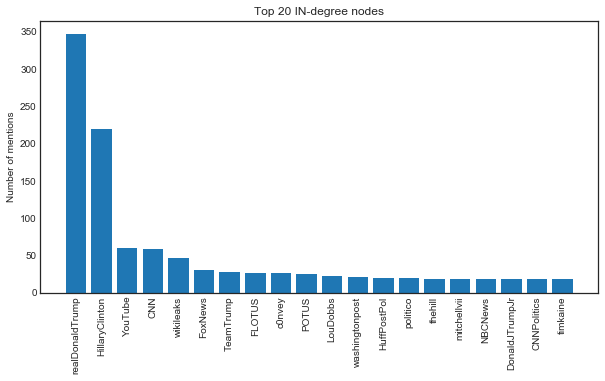

In [63]:
# plot a chart with the top 20 in-degree nodes
# set figure size
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

# create a list of the top user names
top_accounts = [i[0] for i in top_20_in]

# create a list of the their in-degree values
in_degrees = [i[1] for i in top_20_in]

# create a sequence from 0 to 19 to display bars in order by size
y_pos = np.arange(len(in_degrees))

# generate the bar chart
plt.bar(sorted(top_accounts), in_degrees)

# set chart tick lables and their rotation
plt.xticks(y_pos, top_accounts, rotation='vertical')

# set the y-axis label
plt.ylabel('Number of mentions')

# set the chart title
plt.title('Top 20 IN-degree nodes')

plt.show()

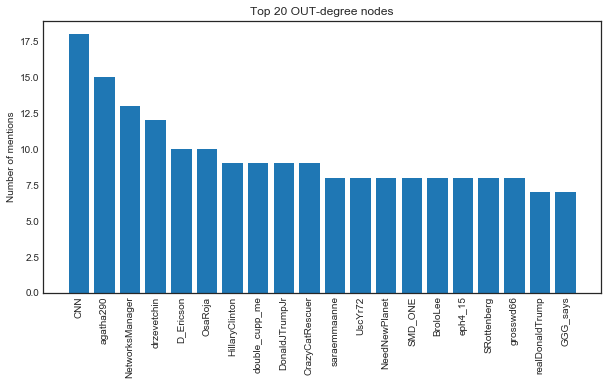

In [64]:
# plot a chart with the top 20 in-degree nodes
# set figure size
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

# create a list of the top user names
top_out_accounts = [i[0] for i in top_20_out]

# create a list of the their out-degree values
out_degrees = [i[1] for i in top_20_out]

# create a sequence from 0 to 19 to display bars in order by size
y_out_pos = np.arange(len(out_degrees))

# generate the bar chart
plt.bar(sorted(top_out_accounts), out_degrees)

# set chart tick lables and their rotation
plt.xticks(y_out_pos, top_out_accounts, rotation='vertical')

# set the y-axis label
plt.ylabel('Number of mentions')

# set the chart title
plt.title('Top 20 OUT-degree nodes')

plt.show()

The realDonaldTrump account is by far the most mentioned in the network, followed by HillaryClinton. CNN was the top content producer, having mentioned or retweeted 18 other users.

### Betweeness centrality

One of the most interesting metrics in our analyis is *betweenness centrality*. It is **the measure of how many times a node is part of the path between two other nodes.** Nodes with high betweenness may be influential because of their capacity to control information passing between others. They are also the ones whose removal from the network will most disrupt communications.

*Mathematically, let $n_{s,t}^{i}$ be the number of paths from $s$ to $t$ that pass through $i$ and let $n_{s,t}$ be the total number of paths from $s$ to $t$. Recall that a path is not necessarily unique and the paths between a pair of nodes need not be node-independent, meaning they may pass through some of the same nodes. Then the betweenness centrality of node $i$ is:*

$\displaystyle{b_i = \sum_{s, t} w_{s,t}^{i} = \sum_{s, t} \frac{n_{s,t}^{i}}{n_{s,t}}}$

*where by convention the ratio $w_{s,t}^{i} = 0$ if $n_{s,t} = 0$. Notice that each pair of nodes $s, t$ contribute to the sum for $i$ with a weight $w_{s,t}^{i}$ between 0 and 1 expressing the betweenness of $i$ with respect to the pair $s, t$.*
    
source: https://www.sci.unich.it/~francesc/teaching/network/betweeness.html

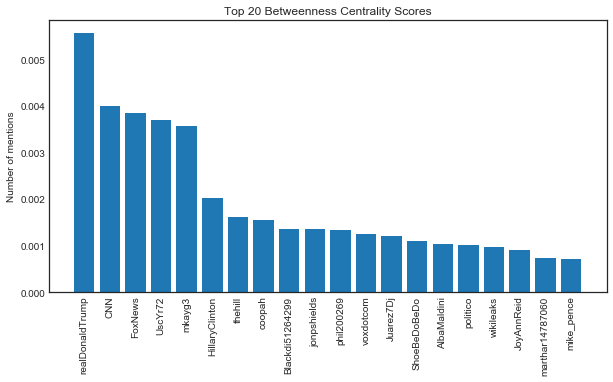

In [65]:
# calculate the betweenness centrality scores and store in an ordered list
betweenness = sorted(nx.betweenness_centrality(G).items(), key=itemgetter(1), reverse=True)[:20]

# set the size of the chart
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

# create a list of the top user names
top_betweenness = [i[0] for i in betweenness]

# create a list of their betweenness centrality scores 
BC = [i[1] for i in betweenness]

# create a sequence from 0 to 19 to display bars in order by size
y_pos = np.arange(len(BC))

# generate the bar chart
plt.bar(y_pos, BC)

# set x-axis labels and their rotation
plt.xticks(y_pos, top_betweeness, rotation='vertical')

# set y-axis labels
plt.ylabel('Number of mentions')

# set chart title
plt.title('Top 20 Betweenness Centrality Scores')
plt.show()

### Clustering coefficient

The **global clustering coefficient** is a measure of how tightly knit a network is. The local clustering coefficient of a node describes the probability that any two nodes it is linked to will also be linked to each other. The higher the clustering score, the more redundant the node.

The clustering coefficient for a node $i$ with $k$ links (degree $k_i$) can be calculated as:

$C_i= \frac{2L_i}{k_i(k_i-1)}$

Where $L_i$ is the number of links between the $k$ neighbors of node $i$. $C_i$ ranges from 0 to 1 and indicates the probability that any two neighbors of node $i$ will be linked to one another.

Another way to refer to clustering is local density. The more connected a network's nodes, the easier it is for information to flow without disruptions. The information flowing through dense networks is harder to be controlled (or censored).

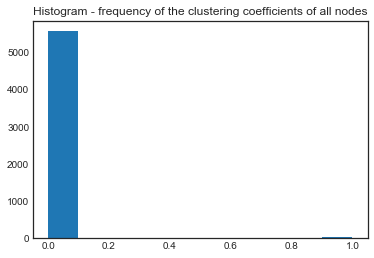

Average network clustering coefficient: 0.006387539183870326


In [66]:
# create an undirected copy of the graph
UG = G.to_undirected()

# create a list of how often nodes share links
clustering = list(nx.clustering(UG).values())

# generate a histogram
plt.hist(clustering)

# set the chart title
plt.title('Histogram - frequency of the clustering coefficients of all nodes')
plt.show()

print('Average network clustering coefficient:', nx.average_clustering(UG))

The clustering coefficient is extremely low, indicating that most of the information was exchanged by individual pairs of nodes. Again, this is not surprising, considering that our tweets were collected in just 3 minutes and 40 seconds.

Let's look at the local clustering coefficient of the top 20 nodes with the highest degree scores, and compare them with the two presidential candidates.

In [67]:
# create a sorted dictionary with the most connected nodes
top_20_degrees = sorted(dict(G.degree()).items(), key=itemgetter(1), reverse=True)[:20]

# create a list of the 20 most connected users
top_nodes = [i[0] for i in top_20_degrees]

# create an empty dictionary
top_nodes_avg_clustering = {}

# iterate over the undirected graph
for i in UG:
    
    # create a list of all neighbors for each user in the network
    neighbors = list(nx.all_neighbors(UG, i))
    
    # calculate the average clustering of nodes and store in a dictionary
    top_nodes_avg_clustering[i] = nx.average_clustering(UG, nodes=neighbors)

# create of list of the top 20 user names with the greatest clustering scores
names = [i[0] for i in sorted(top_nodes_avg_clustering.items(),
                              key=itemgetter(1), reverse=True)[:20]]

# create of list of the top 20 clustering scores
avg_clustering = [i[1] for i in sorted(top_nodes_avg_clustering.items(),
                                       key=itemgetter(1), reverse=True)[:20]]

# add Trump and Hillary accounts to names list
names.extend(['realDonaldTrump', 'HillaryClinton'])

# add Trump and Hillary clustering scores to scores list
avg_clustering.extend(
    [top_nodes_avg_clustering['realDonaldTrump'], 
     top_nodes_avg_clustering['HillaryClinton']])

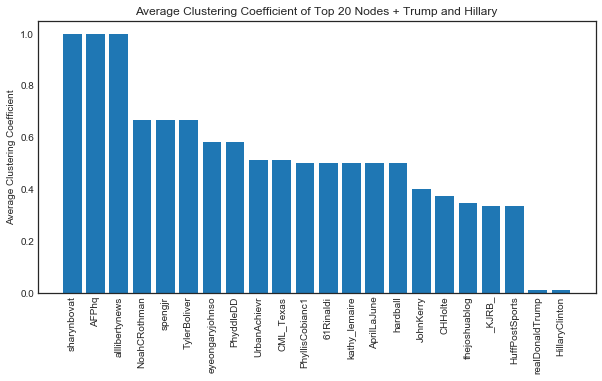

In [68]:
# create a sequence from 0 to 19 to display bars in order by size
order = [i for i in range(len(names))]

# set chart size
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10) 

# generate the bar chart
plt.bar(order, avg_clustering)

# set the x-axis labels
plt.xticks(order, names, rotation='vertical')

# set the y-axis label
plt.ylabel('Average Clustering Coefficient')

# set the title
plt.title('Average Clustering Coefficient of Top 20 Nodes + Trump and Hillary')
plt.show()

The realDonaldTrump and HillaryClinton accounts have much lower local clustering coefficients than the other accounts. That's because both have very high in-degree scores (they are very frequently mentioned by other users), both accounts rarely mentioned or retweeted other users.

### Shortest path

In our final analysis, we'll visualize the entire network graph and trace the shortest path between the @realDonaldTrump and @HillaryClinton, and the @POTUS accounts.

POTUS is an acronym for "President of the United States". The account is managed by the White House.

In [49]:
# reset index to ensure that the index is sequential
tweets.reset_index(drop=True, inplace=True)

# create an empty NetworkX graph object
G = nx.DiGraph()

# iterate over the tweets data frame
for i, username in enumerate(tweets.username):
    for user_mentioned in tweets.user_mentions.loc[i]:
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[username, user_mentioned]['weight']+=.001
            G.edges[username, user_mentioned]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                username, user_mentioned, weight=.001, 
                color=tweets.color.loc[i])

# iterate over the tweets data frame
for i, quoted_user in enumerate(tweets[tweets.quoted_user.notnull()].quoted_user):
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[quoted_user, tweets.username.loc[i]]['weight']+=.001
            G.edges[quoted_user, tweets.username.loc[i]]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                quoted_user, tweets.username.loc[i], weight=.001, 
                color=tweets.color.loc[i])

In [69]:
# create an empty NetworkX directed graph object
G = nx.DiGraph()

# iterate over the tweets data frame
for i, username in enumerate(tweets.username):
    for user_mentioned in tweets.user_mentions.loc[i]:
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[username, user_mentioned]['weight']+=.001
            G.edges[username, user_mentioned]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                username, user_mentioned, weight=.001, 
                color=tweets.color.loc[i])

# iterate over the tweets data frame
for i, quoted_user in enumerate(tweets[tweets.quoted_user.notnull()].quoted_user):
        # modify edge weights when connections between users are repeated, and assign node colors
        try:
            G.edges[quoted_user, tweets.username.loc[i]]['weight']+=.001
            G.edges[quoted_user, tweets.username.loc[i]]['color'] = tweets.color.loc[i]
        # create node connections in case there are none, and assign node colors
        except KeyError:
            G.add_edge(
                quoted_user, tweets.username.loc[i], weight=.001, 
                color=tweets.color.loc[i])

In [70]:
# create and print the names of the nodes in the shortest path between accounts
shortest = nx.shortest_path(G, source='HillaryClinton', target='POTUS')
shortest

['HillaryClinton',
 'Blackdi51264299',
 'phil200269',
 'Juarez7Dj',
 'realDonaldTrump',
 'AlbaMaldini',
 'voxdotcom',
 'marthar14787060',
 'JoyAnnReid',
 'SallyAlbright',
 'POTUS']

In [71]:
# create and print the names of the nodes in the shortest path between accounts
shortest = nx.shortest_path(G, source='realDonaldTrump', target='POTUS')
shortest

['realDonaldTrump',
 'AlbaMaldini',
 'voxdotcom',
 'marthar14787060',
 'JoyAnnReid',
 'SallyAlbright',
 'POTUS']

In [72]:
# create lists of network edges and weights
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())

# extract node colors
colors = tuple(nx.get_edge_attributes(G,'color').values())

# create a dictionary with the nodes and their respective degrees
degrees = dict(nx.degree(G))

# set graph figure size
fig = plt.figure()
fig.set_figheight(300)
fig.set_figwidth(300) 

# set graph title
fig.suptitle('Shortest Path from realDonaldTrump to POTUS',fontsize=400)

# set graph to spring layout
pos=nx.spring_layout(G)

# set and draw the graph's parameters
nx.draw_networkx(G,
                 pos, # Positions the nodes relative to each other
                 with_labels=False,
                 arrows=False,
                 node_size=[(v*1000) for v in degrees.values()],
                 cmap=plt.cm.hot, # The color palette to use to color the nodes
                 node_color=colors, # The number of shades of color to use
                 edgelist=edges,
                 #edge_cmap=plt.cm.hot,
                 edge_color='#C6DEFF',
                 alpha=.7,
                 width=.00005, # Edge width
                 )

# create a list with tuples of each pair of nodes in the shortest path
path_edges = list(zip(shortest,shortest[1:]))

# overlay a graph with the nodes in the shortest path. Set the color to red
nx.draw_networkx_nodes(G,
                       pos,
                       with_labels=True,
                       node_size=[(v*1000) for v in degrees.values()],
                       nodelist=shortest,
                       node_color='#B22222')

# overlay a graph with the links in the shortest path. Set the color to red
nx.draw_networkx_edges(G,
                       pos,
                       with_labels=True,
                       edgelist=path_edges,
                       edge_color='#B22222',
                       width=15)

# draw the graph and save to file
plt.axis('off')
fig.savefig('all_tweets_path.pdf')

### Shortest path from @realDonaldTrump to @POTUS

<img src="shortest_path.png"/>

# Conclusion

### Natural Language Processing:
We have used a combination of TF-IDF modelling, unsupervised clustering, Non-negative Matrix Factorization and Cosine Similarity to extract key topics from a sample of +5,000 tweets.

Topics tend to be nested - there are usually relevant sub-topics within topics that were sorted with unsupervised clustering techniques. For example, while component class 12_0 grouped tweets about "people" in general, component class 12_1 had messages that were specifically related to "black people."

Smaller component clusters will tend to have higher cosine similarity scores and consist of tweets with highly similar topics. Larger component classes (with +500 samples) have a mixture of undefined topics.

We were able to sort 2,797 tweets (53% of all unique tweets) into component classes with cosine similarity scores of at least 0.34 - which from an anecdotal analysis share similar topics. More work would be needed to sort the larger classes that have cosine similarity scores lower than 0.34.

### Network Analysis:
Our Twitter data set is a snapshot of only 4 minutes and 40 seconds of the political debate around the 2016 US Presidential Elections in that social network.

We were able to generate network graphs and visualize the most influential Twitter users according to specific topics of interest (for topics featured in component classes with cosine similarity scores above 0.34).

Most users only communicated once during the observation period of our data set. The users @realDonaldTrump and @HillaryClinton had the highest in-degree scores and were the handles most mentioned by other users. The two most quoted or re-tweeted accounts were @CNN and @agatha290.

We found the most influential users by sorting accounts by their betweeness centrality scores (which measures how many times a node is part of the path between two other nodes). Nodes with greater betweenness centrality scores may be influential because of their capacity to control information passing between others. The top 5 most influential users were @realDonaldTrump, @CNN, @FoxNews, @UscYr72, @mkayg3, respectively.

Our network's clustering coefficient (which measures how tightly knit a network is) was very low, once again due to the short time span of our data set.

Finally, we found out that there were only five Twitter accounts separating the @realDonaldTrump user from the White House's @POTUS account; and nine accounts between @HillaryClinton and @POTUS.